In [1]:
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

num_qubits = 4

# ansatz = TwoLocal(num_qubits, "ry", "cz")

entangler_map = [[0, 1], [1, 2], [2,3], [3,0]]  # entangle the first and last two-way
ansatz = TwoLocal(num_qubits, 'ry', 'cx', entangler_map, reps=1, skip_final_rotation_layer=True)

optimizer = SLSQP(maxiter=1000)

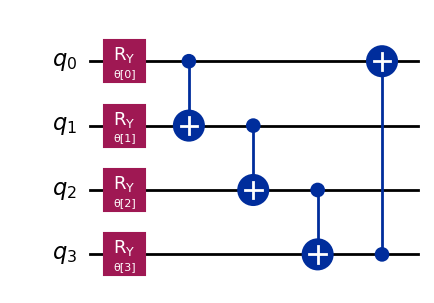

In [2]:
ansatz.decompose().draw('mpl')  # note, that the parameters are the same!

In [3]:
from qiskit.primitives import Estimator

estimator = Estimator()

In [4]:
from qiskit_algorithms import VQE

vqe = VQE(estimator, ansatz, optimizer)

In [5]:
from qiskit.quantum_info import SparsePauliOp
# H=z1x4+2y0y3
# H2_op = SparsePauliOp.from_list([("XIIZI", 1), 
#                                  ("IYIIY", 2)])

H2_op = SparsePauliOp.from_list(
    [("IIII", -0.81054), 
     ("IZIZ", 0.16614), 
     ("ZIZI", 0.16892), 
     ("ZIII", 0.17218), 
     ("IIZI", 0.17218), 
     ("IZII", -0.22573), 
     ("IIIZ", -0.22573), 
     ("ZZII", 0.12091), 
     ("IIZZ", 0.12091), 
     ("ZIIZ", 0.166145), 
     ("IZZI", 0.166145), 
     ("YYYY", 0.04523), 
     ("XXYY", 0.04523), 
     ("YYXX", 0.04523), 
     ("XXXX", 0.04523)]
)



In [6]:
# %%time
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 41,
    'eigenvalue': -1.865715917478926,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7f81e2d23b30>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -3.1416846836122834,
                              ParameterVectorElement(θ[1]): -0.22353878019398438,
                              ParameterVectorElement(θ[2]): -3.1415574755234754,
                              ParameterVectorElement(θ[3]): -3.141606387787628},
    'optimal_point': array([-3.14168468, -0.22353878, -3.14155748, -3.14160639]),
    'optimal_value': -1.865715917478926,
    'optimizer_evals': None,
    'optimizer_result': <qiskit_algorithms.optimizers.optimizer.OptimizerResult object at 0x7f81e289a3f0>,
    'optimizer_time': 0.18816328048706055}


In [7]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.86572


In [8]:
# define callback
# note: Re-run this cell to restart lists before training
counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


# define Aer Estimator for noiseless statevector simulation
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

seed = 170
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

In [26]:
iterations = 125

from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.optimizers import SPSA
spsa = SPSA(maxiter=iterations)

# instantiate and run VQE
from qiskit_algorithms import VQE

vqe = VQE(noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}")

VQE on Aer qasm simulator (no noise): -1.18724
Delta from reference energy value is 0.67848


Text(0.5, 1.0, 'Convergence with no noise')

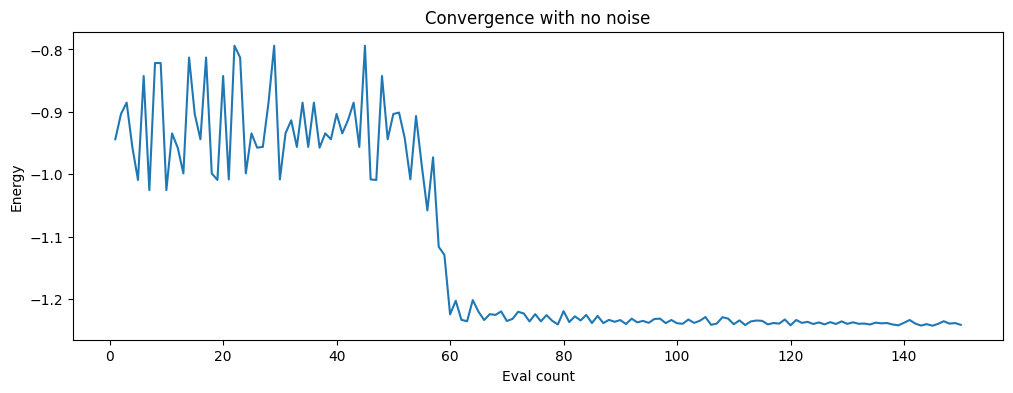

In [27]:
import pylab

# pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts[:150], values[:150])
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

In [28]:
print(values)

[-0.9438876074218749, -0.903402109375, -0.885210361328125, -0.9561303906249999, -1.0090629980468748, -0.8425178515624999, -1.02539943359375, -0.8217935058593749, -0.8217935058593749, -1.02539943359375, -0.934471484375, -0.95735119140625, -0.9985980175781252, -0.812936015625, -0.903402109375, -0.9438876074218749, -0.812936015625, -0.9985980175781252, -1.0090629980468748, -0.8425178515624999, -1.0082523828124998, -0.79404955078125, -0.812936015625, -0.9985980175781252, -0.934471484375, -0.95735119140625, -0.9561303906249999, -0.885210361328125, -0.79404955078125, -1.0082523828124998, -0.93440140625, -0.9135003417968749, -0.9561303906249999, -0.885210361328125, -0.9561303906249999, -0.885210361328125, -0.95735119140625, -0.934471484375, -0.9438876074218749, -0.903402109375, -0.93440140625, -0.9135003417968749, -0.885210361328125, -0.9561303906249999, -0.79404955078125, -1.0082523828124998, -1.0090629980468748, -0.8425178515624999, -0.9438876074218749, -0.903402109375, -0.9010851171875, -0

In [21]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import GenericBackendV2

coupling_map = [(0, 1), (1, 2), (2, 3), (3, 4)]
device = GenericBackendV2(num_qubits=5, coupling_map=coupling_map, seed=54)

noise_model = NoiseModel.from_backend(device)

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'measure', 'x', 'sx', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('cx', (0, 1)), ('cx', (1, 2)), ('cx', (2, 3)), ('cx', (3, 4)), ('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [22]:
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

In [31]:
counts = []
values = []

vqe.estimator = noisy_estimator

result1 = vqe.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}")

VQE on Aer qasm simulator (with noise): -1.24178
Delta from reference energy value is 0.62394


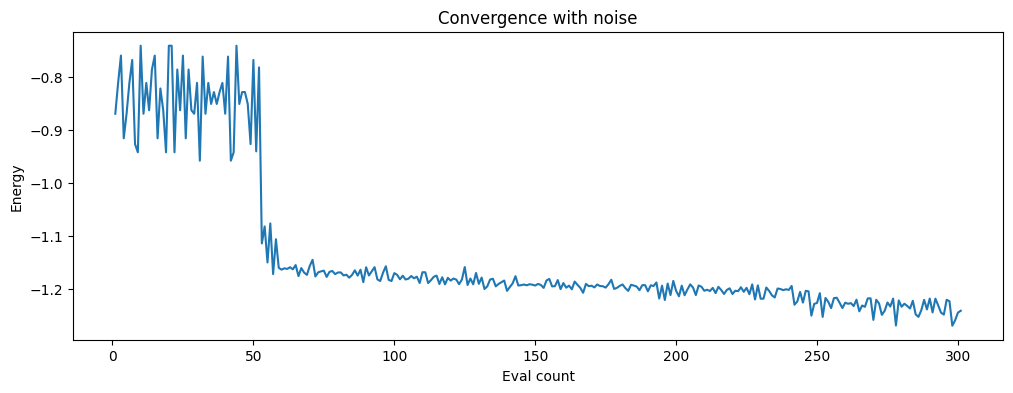

In [32]:
if counts or values:
    pylab.rcParams["figure.figsize"] = (12, 4)
    pylab.plot(counts, values)
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Convergence with noise")

In [29]:
print(values)

[-0.9438876074218749, -0.903402109375, -0.885210361328125, -0.9561303906249999, -1.0090629980468748, -0.8425178515624999, -1.02539943359375, -0.8217935058593749, -0.8217935058593749, -1.02539943359375, -0.934471484375, -0.95735119140625, -0.9985980175781252, -0.812936015625, -0.903402109375, -0.9438876074218749, -0.812936015625, -0.9985980175781252, -1.0090629980468748, -0.8425178515624999, -1.0082523828124998, -0.79404955078125, -0.812936015625, -0.9985980175781252, -0.934471484375, -0.95735119140625, -0.9561303906249999, -0.885210361328125, -0.79404955078125, -1.0082523828124998, -0.93440140625, -0.9135003417968749, -0.9561303906249999, -0.885210361328125, -0.9561303906249999, -0.885210361328125, -0.95735119140625, -0.934471484375, -0.9438876074218749, -0.903402109375, -0.93440140625, -0.9135003417968749, -0.885210361328125, -0.9561303906249999, -0.79404955078125, -1.0082523828124998, -1.0090629980468748, -0.8425178515624999, -0.9438876074218749, -0.903402109375, -0.9010851171875, -0

In [ ]:
plt.plot()